# 04 — Classification vs Regression

Purpose: learn how problem type drives output design, target encoding, and loss selection by fitting both a regression model and a classifier on synthetic data and comparing behaviors.

## Learning goals
- Distinguish regression outputs (real-valued) from classification outputs (class probability/score).
- Use correct loss functions: MSE for regression, BCE for binary classification.
- Visualize fitted functions and decision boundaries on 2D data.

## Prerequisites
- Notebook 03 (affine + sigmoid).
- Basic understanding of loss minimization.
- Comfort with NumPy matrix operations.

## Key ideas
- The output layer is an API: it must match the semantics you need at inference.
- Regression predicts a number; classification predicts a score used for a decision.
- Loss must match the output semantics (and be numerically stable).

## Minimal theory
- Regression: `a = xW + b`, minimize `MSE(y, a)`.
- Binary classification: `a = sigmoid(xW + b)`, minimize `BCE(y, a)`.
- With enough overlap/noise, perfect accuracy may be impossible; evaluate realistically.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
rng = np.random.default_rng(SEED)

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def mse(a, y):
    return np.mean((a - y)**2)

def bce(a, y, eps=1e-12):
    a = np.clip(a, eps, 1-eps)
    return -np.mean(y*np.log(a) + (1-y)*np.log(1-a))

def train_linear_regression(x, y, lr=0.1, steps=400):
    N, D = x.shape
    W = rng.normal(0, 0.1, size=(D, 1))
    b = np.zeros((1, 1))
    losses = []
    for _ in range(steps):
        a = x @ W + b
        L = mse(a, y)
        da = (2.0*(a - y))/N
        dW = x.T @ da
        db = np.sum(da, axis=0, keepdims=True)
        W -= lr*dW
        b -= lr*db
        losses.append(L)
    return W, b, np.array(losses)

def train_logreg(x, y, lr=0.5, steps=600):
    N, D = x.shape
    W = rng.normal(0, 0.1, size=(D, 1))
    b = np.zeros((1, 1))
    losses = []
    for _ in range(steps):
        z = x @ W + b
        a = sigmoid(z)
        L = bce(a, y)
        dz = (a - y)/N
        dW = x.T @ dz
        db = np.sum(dz, axis=0, keepdims=True)
        W -= lr*dW
        b -= lr*db
        losses.append(L)
    return W, b, np.array(losses)

# Dataset A (regression): y = sin(x) + noise
N = 250
x_reg = rng.uniform(-3.0, 3.0, size=(N,1))
y_reg = np.sin(x_reg) + 0.15*rng.normal(size=(N,1))
X_reg = np.c_[x_reg, x_reg**2, x_reg**3]  # simple polynomial features
X_reg_mean = X_reg.mean(axis=0)
X_reg_std = X_reg.std(axis=0) + 1e-8
X_reg = (X_reg - X_reg_mean) / X_reg_std

print('Regression X shape:', X_reg.shape, 'y shape:', y_reg.shape)

# Dataset B (classification): 2D blobs with overlap
M = 400
x0 = rng.normal(loc=(-1.0, -0.6), scale=0.8, size=(M//2, 2))
x1 = rng.normal(loc=(+1.0, +0.9), scale=0.8, size=(M//2, 2))
x_clf = np.vstack([x0, x1])
y_clf = np.vstack([np.zeros((M//2,1)), np.ones((M//2,1))])
idx = rng.permutation(M)
x_clf, y_clf = x_clf[idx], y_clf[idx]
print('Classification x shape:', x_clf.shape, 'y shape:', y_clf.shape)

Regression X shape: (250, 3) y shape: (250, 1)
Classification x shape: (400, 2) y shape: (400, 1)


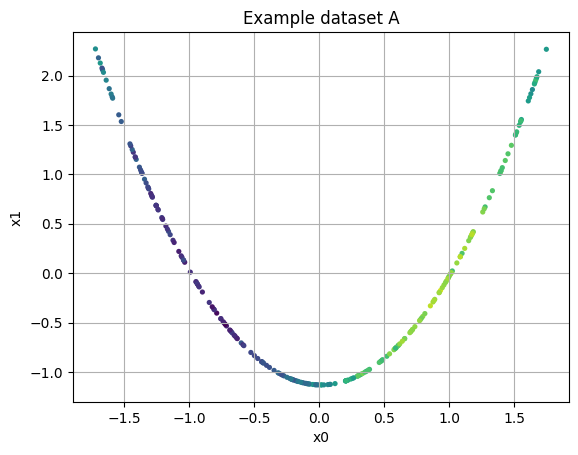

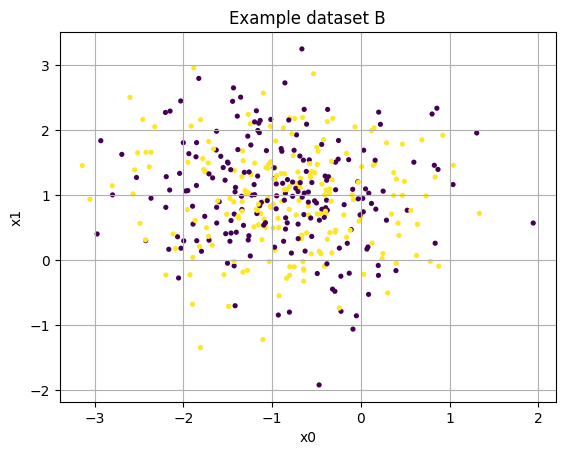

In [8]:
plt.scatter(X_reg[:,0], X_reg[:,1], c=y_reg, s=14, edgecolors='none')
plt.title("Example dataset A")
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid(True)
plt.show()

plt.scatter(x0, x1, c=y_clf, s=14, edgecolors='none')
plt.title("Example dataset B")
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid(True)
plt.show()


## Step-by-step experiments
1. Train a regression model (polynomial linear regression) and plot the fitted curve.
2. Train a binary classifier (logistic regression) and plot the decision boundary.
3. Compare losses and interpret outputs.

Regression final loss: 0.02390294325822037
Classification final loss: 0.1576492430311619


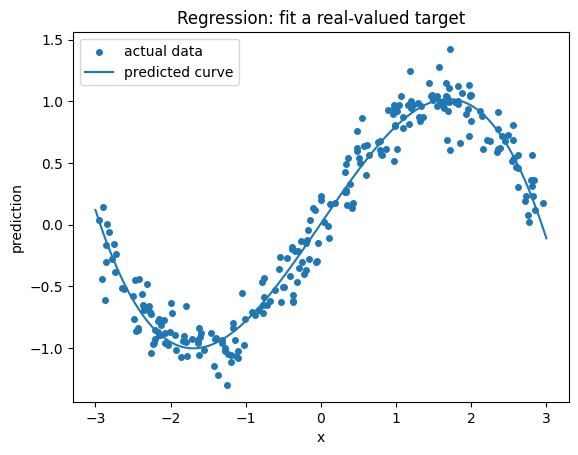

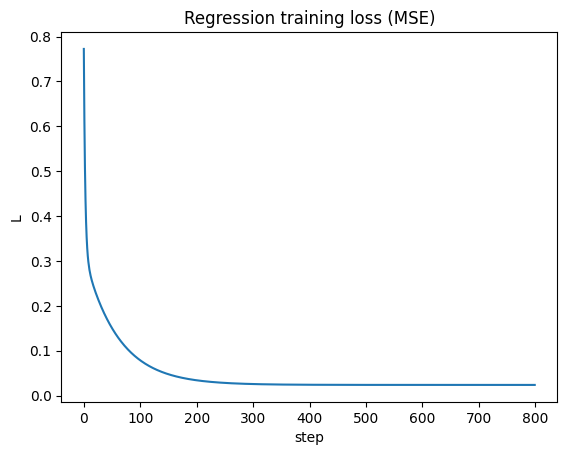

In [12]:
W_r, b_r, L_r = train_linear_regression(X_reg, y_reg, lr=0.05, steps=800)
print('Regression final loss:', L_r[-1])

W_c, b_c, L_c = train_logreg(x_clf, y_clf, lr=0.8, steps=700)
print('Classification final loss:', L_c[-1])

# Plot 1: regression fit
plt.figure()
plt.scatter(x_reg[:,0], y_reg[:,0], s=16, label='actual data')
xs = np.linspace(-3.0, 3.0, 400).reshape(-1,1)
Xs = np.c_[xs, xs**2, xs**3]
Xs = (Xs - X_reg_mean) / X_reg_std
ys = (Xs @ W_r + b_r)[:,0]
plt.plot(xs[:,0], ys, label='predicted curve')
plt.title('Regression: fit a real-valued target')
plt.xlabel('x')
plt.ylabel('prediction')
plt.legend()
plt.show()

# Plot 2: regression loss
plt.figure()
plt.plot(L_r)
plt.title('Regression training loss (MSE)')
plt.xlabel('step')
plt.ylabel('L')
plt.show()


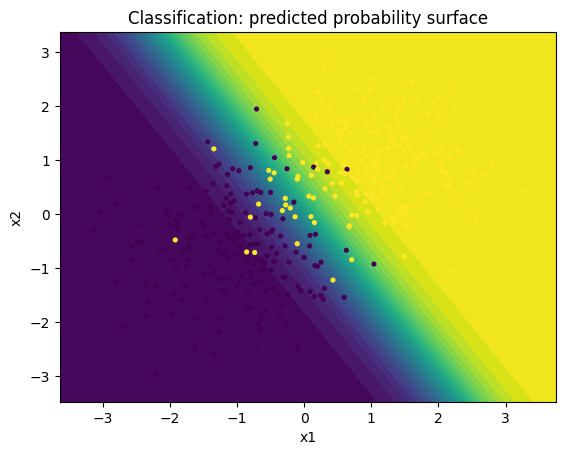

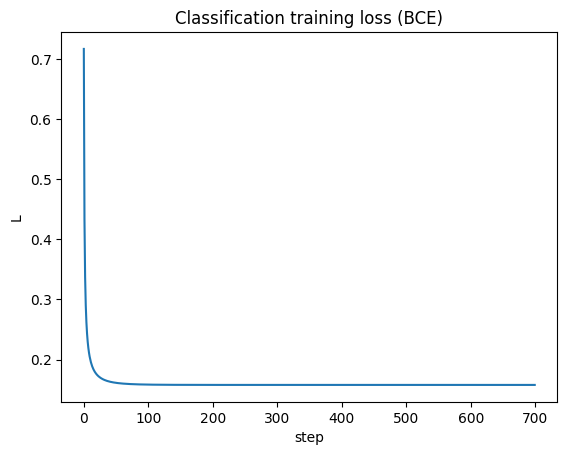

Accuracy @0.5: 0.94


In [14]:
def plot_boundary_logreg(x, y, W, b, title):
    x1_min, x1_max = x[:,0].min()-0.5, x[:,0].max()+0.5
    x2_min, x2_max = x[:,1].min()-0.5, x[:,1].max()+0.5
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 250), np.linspace(x2_min, x2_max, 250))
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    p = sigmoid(grid @ W + b).reshape(xx1.shape)
    plt.figure()
    plt.contourf(xx1, xx2, p, levels=30)
    plt.scatter(x[:,0], x[:,1], c=y[:,0], s=14, edgecolors='none', label='actual data')
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

plot_boundary_logreg(x_clf, y_clf, W_c, b_c, 'Classification: predicted probability surface')

plt.figure()
plt.plot(L_c)
plt.title('Classification training loss (BCE)')
plt.xlabel('step')
plt.ylabel('L')
plt.show()

# Simple accuracy at threshold 0.5
p = sigmoid(x_clf @ W_c + b_c)
yhat = (p >= 0.5).astype(float)
acc = (yhat == y_clf).mean()
print('Accuracy @0.5:', acc)

## Reflection questions
1. What is the meaning of a regression prediction vs a classification probability?
2. Why does a classifier still output a number (probability) before producing a label?
3. How does noise/overlap limit maximum achievable accuracy?
4. When would MAE be preferable to MSE?
5. What is a failure mode of using MSE for classification?

## Optional extensions
1. Make the regression function piecewise and see polynomial limits.
2. Add a third class and discuss softmax vs sigmoid outputs.
3. Explore threshold changes (0.3, 0.7) and observe precision/recall shifts.

## Summary
- Regression and classification require different output semantics.
- Loss functions must match those semantics.
- Visuals reveal mismatch quickly (bad boundaries or bad curves).
- Even “simple” linear models teach the core design constraints.
- Next: architecture choices beyond a single unit.